***
***
# <div align="center"><font color='RED'><b>AREEBA FATAH </b></font></div>
***
# <div align="center"><font color='BLUE'><b>GENERATIVE AI</b></font></div>
***
# <div align="center"><font color='RED'><b>21I-0349</b></font></div>
***
# <div align="center"><font color='BLUE'><b>ASSIGNMENT 2</b></font></div>
***
# <div align="center"><font color='RED'><b>QUESTION 4 </b></font></div>

<br>

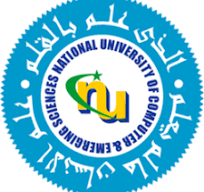

# STEP 1: IMPORTING THE REQUIRED LIBRARIES

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import pickle
import matplotlib.pyplot as plt

## 1.1 SETTING UP THE DEVICE

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 2: DATA PREPROCESSING AND LOADING
**Steps**:
    --<br>Reading both the sketches and photos till max limit as dataset is too large.
    --<br>Preprocessing data i.e. resizing and normalizing while converting to tensors
    --<br>Preparing train loader

In [4]:
class FaceSketchDataset(Dataset):
    def __init__(self,sketch_dir,photo_dir,transforms=None,max_images=500):
        self.sketch_dir=sketch_dir
        self.photo_dir=photo_dir
        self.transforms=transforms
        self.sketch_images=os.listdir(sketch_dir)[:max_images]
        
    def __len__(self):
        return len(self.sketch_images)
    
    def __getitem__(self, idx):
        sketch_path=os.path.join(self.sketch_dir,self.sketch_images[idx])
        photo_path=os.path.join(self.photo_dir,self.sketch_images[idx])
        sketch_img=Image.open(sketch_path).convert('L')
        photo_img=Image.open(photo_path).convert('RGB')
        if self.transforms:
            sketch_img=self.transforms[0](sketch_img)
            photo_img=self.transforms[1](photo_img)
        return sketch_img,photo_img


In [4]:
transform_sketch=transforms.Compose([
                                    transforms.Resize((256,256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])

transform_photo=transforms.Compose([
                                    transforms.Resize((256,256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
                                   ])

train_dataset=FaceSketchDataset(
                                sketch_dir='/kaggle/input/person-face-sketches/train/sketches',
                                photo_dir='/kaggle/input/person-face-sketches/train/photos',
                                transforms=(transform_sketch,transform_photo),
                                max_images=1000
                                )
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)

# STEP 3 DESIGNING NETWORKS FOR CYCLEGAN
## 3.1 GENERATORS

### 3.1.1 GeneratorSketchToPhoto
5 Conv2d layers for downsampling <br>
4 ConvTranspose2d layers for upsampling <br>
ReLU activation used after each Conv/ConvTranspose layer (except output)<br>
Tanh activation at the output layer (to normalize the output between -1 and 1)

In [10]:
class GeneratorSketchToPhoto(nn.Module):
    def __init__(self):
        super(GeneratorSketchToPhoto,self).__init__()
        self.model=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=7,stride=1,padding=3),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),  
            nn.BatchNorm2d(256),  
            nn.ReLU(inplace=True),  
            nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding=1,output_padding=1),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True),  
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(64,3,kernel_size=7,stride=1,padding=3),  
            nn.Tanh()  
        )

    def forward(self,x):
        return self.model(x)


## 3.1.2 GeneratorPhotoToSketch
5 Conv2d layers for downsampling <br>
4 ConvTranspose2d layers for upsampling <br>
ReLU activation used after each Conv/ConvTranspose layer (except output)<br>
Tanh activation at the output layer (to normalize the output between -1 and 1)

In [11]:
class GeneratorPhotoToSketch(nn.Module):
    def __init__(self):
        super(GeneratorPhotoToSketch,self).__init__()
        self.model=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride=1,padding=3),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),  
            nn.BatchNorm2d(256),  
            nn.ReLU(inplace=True),  
            nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding=1,output_padding=1),  
            nn.BatchNorm2d(128),  
            nn.ReLU(inplace=True),  
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1),  
            nn.BatchNorm2d(64),  
            nn.ReLU(inplace=True),  
            nn.Conv2d(64,1,kernel_size=7,stride=1,padding=3),  
            nn.Tanh()  
        )

    def forward(self,x):
        return self.model(x)


## 3.2 DISCRIMINATORS

### 3.2.1 DiscriminatorSketch
4 Conv2d layers for downsampling<br>
LeakyReLU activation with a negative slope of 0.2 used after each Conv layer<br>
Batch Normalization applied after each Conv layer (except the output)<br>
Output: 1 channel (discriminator)<br>

In [13]:
class DiscriminatorSketch(nn.Module):
    def __init__(self):
        super(DiscriminatorSketch,self).__init__()
        self.model=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=4,stride=2,padding=1),  
            nn.LeakyReLU(0.2,inplace=True),  
            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1),  
            nn.BatchNorm2d(128),  
            nn.LeakyReLU(0.2,inplace=True),  
            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1),  
            nn.BatchNorm2d(256),  
            nn.LeakyReLU(0.2,inplace=True),  
            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1),  
            nn.BatchNorm2d(512),  
            nn.LeakyReLU(0.2,inplace=True),  
            nn.Conv2d(512,1,kernel_size=4,stride=1,padding=1),  
        )

    def forward(self,x):
        return self.model(x)

### 3.2.2 DiscriminatorPhoto
4 Conv2d layers for downsampling<br>
LeakyReLU activation with a negative slope of 0.2 used after each Conv layer<br>
Batch Normalization applied after each Conv layer (except the output)<br>
Output: 1 channel (discriminator)<br>

In [14]:
class DiscriminatorPhoto(nn.Module):
    def __init__(self):
        super(DiscriminatorPhoto,self).__init__()
        self.model=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1),  
            nn.LeakyReLU(0.2,inplace=True),  
            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1),  
            nn.BatchNorm2d(128),  
            nn.LeakyReLU(0.2,inplace=True),  
            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1),  
            nn.BatchNorm2d(256),  
            nn.LeakyReLU(0.2,inplace=True),  
            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1),  
            nn.BatchNorm2d(512),  
            nn.LeakyReLU(0.2,inplace=True),  
            nn.Conv2d(512,1,kernel_size=4,stride=1,padding=1),  
        )

    def forward(self,x):
        return self.model(x)

# STEP 3: TRAINING

In [15]:
G_XY=GeneratorSketchToPhoto().to(device)
G_YX=GeneratorPhotoToSketch().to(device)
D_X=DiscriminatorSketch().to(device)
D_Y=DiscriminatorPhoto().to(device)

optimizer_G_XY=optim.Adam(G_XY.parameters(),lr=0.0005,betas=(0.5,0.999))
optimizer_G_YX=optim.Adam(G_YX.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizer_D_X=optim.Adam(D_X.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizer_D_Y=optim.Adam(D_Y.parameters(),lr=0.0002,betas=(0.5,0.999))

criterion_gan=nn.MSELoss()
criterion_cycle=nn.L1Loss()
criterion_identity=nn.L1Loss()

lambda_cycle=10.0
lambda_identity=0.5

In [16]:
def train(num_epochs=200):
    losses_G=[]
    losses_D_X=[]
    losses_D_Y=[]
    for epoch in range(num_epochs):
        for i,(sketches,photos) in enumerate(train_loader):
            sketches,photos=sketches.to(device),photos.to(device)

            optimizer_G_XY.zero_grad()
            optimizer_G_YX.zero_grad()

            fake_photos=G_XY(sketches)
            reconstructed_sketches=G_YX(fake_photos)

            fake_sketches=G_YX(photos)
            reconstructed_photos=G_XY(fake_sketches)

            output_D_Y=D_Y(fake_photos)
            loss_G_Y=criterion_gan(output_D_Y,torch.ones_like(output_D_Y))

            output_D_X=D_X(fake_sketches)
            loss_G_X=criterion_gan(output_D_X,torch.ones_like(output_D_X))

            loss_cycle_X=criterion_cycle(reconstructed_sketches,sketches)
            loss_cycle_Y=criterion_cycle(reconstructed_photos,photos)

            loss_identity_X=criterion_identity(G_YX(photos),photos)*lambda_identity
            loss_identity_Y=criterion_identity(G_XY(sketches),sketches)*lambda_identity

            loss_G_XY_total=(loss_G_Y+(loss_cycle_X+loss_cycle_Y)*lambda_cycle+loss_identity_X+loss_identity_Y)
            loss_G_XY_total.backward(retain_graph=True)

            loss_G_YX_total=(loss_G_X+(loss_cycle_X+loss_cycle_Y)*lambda_cycle+loss_identity_X+loss_identity_Y)
            loss_G_YX_total.backward()

            optimizer_G_XY.step()
            optimizer_G_YX.step()

            optimizer_D_X.zero_grad()

            output_D_X_real=D_X(sketches)
            loss_D_X_real=criterion_gan(output_D_X_real,torch.ones_like(output_D_X_real))

            output_D_X_fake=D_X(fake_sketches.detach())
            loss_D_X_fake=criterion_gan(output_D_X_fake,torch.zeros_like(output_D_X_fake))

            loss_D_X_total=(loss_D_X_real+loss_D_X_fake)*0.5
            loss_D_X_total.backward()
            optimizer_D_X.step()

            optimizer_D_Y.zero_grad()

            output_D_Y_real=D_Y(photos)
            loss_D_Y_real=criterion_gan(output_D_Y_real,torch.ones_like(output_D_Y_real))

            output_D_Y_fake=D_Y(fake_photos.detach())
            loss_D_Y_fake=criterion_gan(output_D_Y_fake,torch.zeros_like(output_D_Y_fake))

            loss_D_Y_total=(loss_D_Y_real+loss_D_Y_fake)*0.5
            loss_D_Y_total.backward()
            optimizer_D_Y.step()

            losses_G.append(loss_G_XY_total.item()+loss_G_YX_total.item())
            losses_D_X.append(loss_D_X_total.item())
            losses_D_Y.append(loss_D_Y_total.item())

        if epoch%10==0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss G: {loss_G_XY_total.item()+loss_G_YX_total.item():.4f}, Loss D_X: {loss_D_X_total.item():.4f}, Loss D_Y: {loss_D_Y_total.item():.4f}')
            fake_photos=G_XY(sketches).detach().cpu()
            fake_sketches=G_YX(photos).detach().cpu()

            fig,ax=plt.subplots(1,2,figsize=(12,6))
            ax[0].imshow(vutils.make_grid(fake_photos,normalize=True).permute(1,2,0))
            ax[0].set_title('Fake Photos')
            ax[0].axis('off')

            ax[1].imshow(vutils.make_grid(fake_sketches,normalize=True).permute(1,2,0))
            ax[1].set_title('Fake Sketches')
            ax[1].axis('off')

            plt.show()

    with open('losses.pkl','wb') as f:
        pickle.dump({'losses_G':losses_G,'losses_D_X':losses_D_X,'losses_D_Y':losses_D_Y},f)

    plt.figure(figsize=(12,6))
    plt.plot(losses_G,label='Generator Loss',color='blue')
    plt.plot(losses_D_X,label='Discriminator Loss D_X',color='orange')
    plt.plot(losses_D_Y,label='Discriminator Loss D_Y',color='green')
    plt.title('Training Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig('training_losses.png')
    plt.show()

    torch.save(G_XY.state_dict(),'generator_sketch_to_photo.pth')
    torch.save(G_YX.state_dict(),'generator_photo_to_sketch.pth')
    torch.save(D_X.state_dict(),'discriminator_sketch.pth')
    torch.save(D_Y.state_dict(),'discriminator_photo.pth')


Epoch [1/100], Step [62/63], Loss G: 8.7612, Loss D_X: 0.0777, Loss D_Y: 0.0909


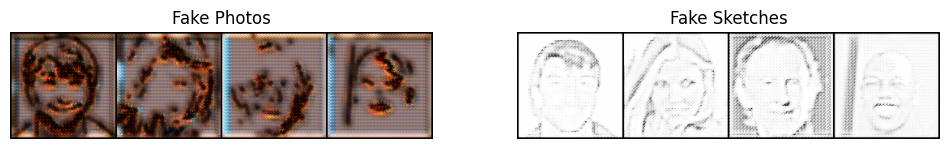

Epoch [11/100], Step [62/63], Loss G: 7.0749, Loss D_X: 0.0810, Loss D_Y: 0.0175


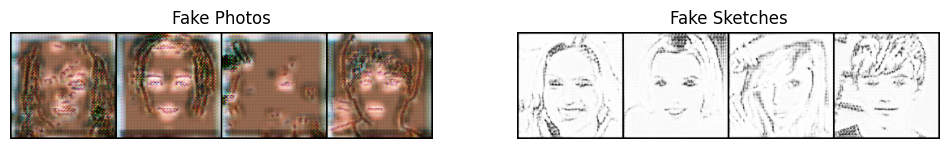

Epoch [21/100], Step [62/63], Loss G: 6.7132, Loss D_X: 0.0553, Loss D_Y: 0.0146


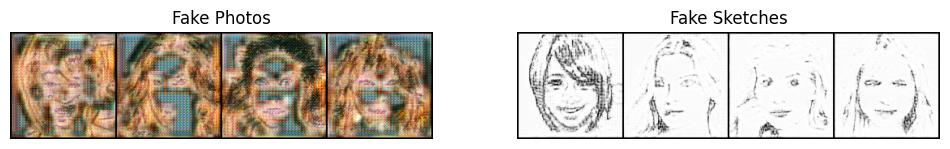

Epoch [31/100], Step [62/63], Loss G: 7.1615, Loss D_X: 0.0429, Loss D_Y: 0.0114


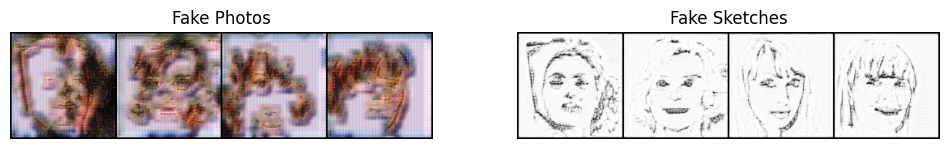

Epoch [41/100], Step [62/63], Loss G: 6.0768, Loss D_X: 0.0414, Loss D_Y: 0.0072


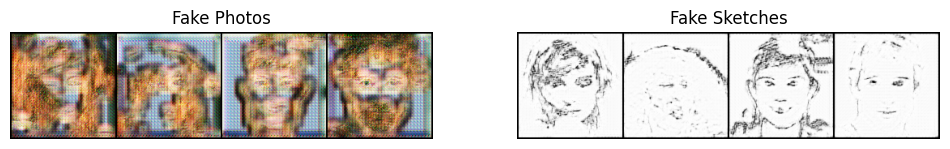

Epoch [51/100], Step [62/63], Loss G: 6.4166, Loss D_X: 0.0470, Loss D_Y: 0.0163


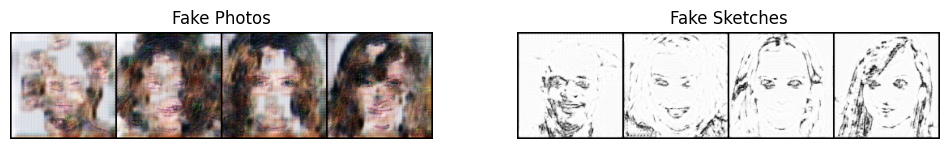

Epoch [61/100], Step [62/63], Loss G: 6.4954, Loss D_X: 0.0425, Loss D_Y: 0.0244


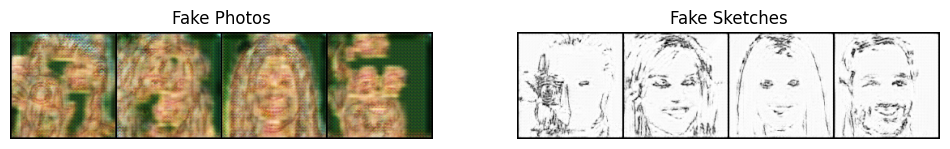

Epoch [71/100], Step [62/63], Loss G: 5.7093, Loss D_X: 0.0312, Loss D_Y: 0.0064


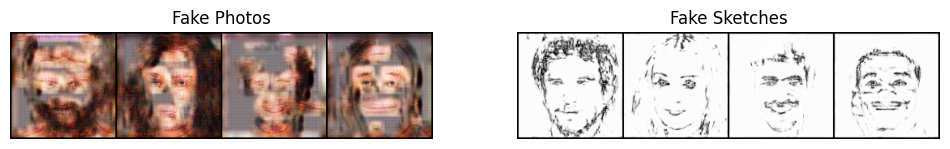

Epoch [81/100], Step [62/63], Loss G: 6.1012, Loss D_X: 0.0324, Loss D_Y: 0.0516


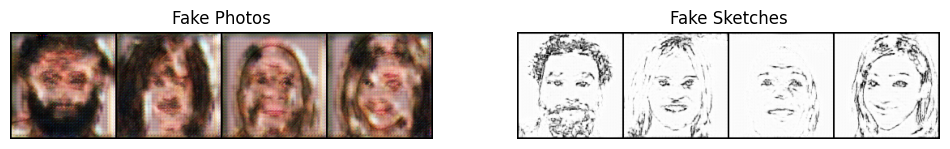

Epoch [91/100], Step [62/63], Loss G: 6.0000, Loss D_X: 0.0106, Loss D_Y: 0.0042


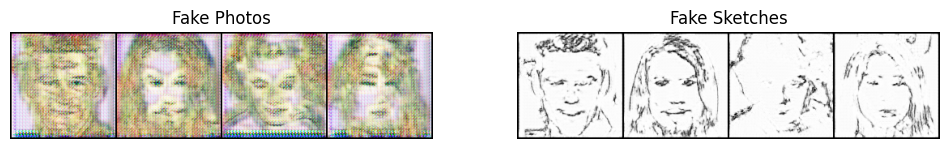

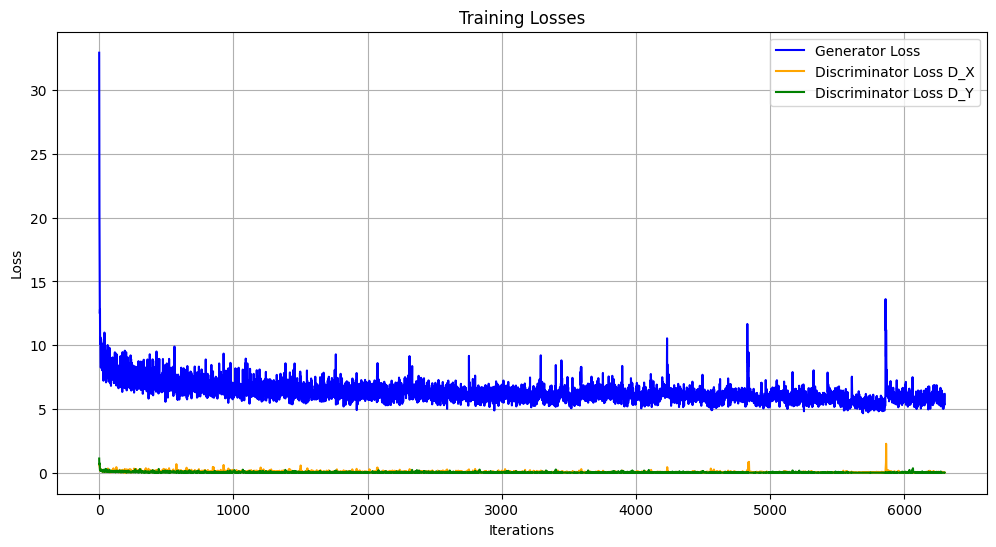

In [13]:
train(num_epochs=100)

***

# <div style="text-align: center;">End</div>


***